## Test Notebook

In [1]:
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.MolStandardize
import rdkit.Chem.MolStandardize.rdMolStandardize
import pandas as pd
import numpy as np
from pyteomics import mgf
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from data_utils import *
import operator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import tensorflow as tf
import os.path


print(sys.version)

RDKit WARNING: [06:57:07] Enabling RDKit 2019.09.1 jupyter extensions
Using TensorFlow backend.


3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


In [2]:
## Check GPU available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def fetch_data(tag):
    
    data = {
        'unique': {
            'filename': 'MS_data_allGNPS_uniqueInchikey14_191101.mgf',
            'path': os.path.dirname(os.path.abspath("")) + "/data/processed/unique8239.csv",
            'size': 8239
        },
        'large': {
            'filename': 'MS_data_allGNPS_smiles_191101.mgf',
            'path': os.path.dirname(os.path.abspath("")) + "/data/processed/large39467.csv",
            'size': 39467
        },
    } 
    
    path = data[tag]['path']
    size = data[tag]['size']
    df = False
    
#     if os.path.exists(path):
#         print("csv exists")
#         df = pd.read_csv(path)#, dtype={'m/z': np.float64, 'intensity': np.float64})
#         if len(df) != size:
#             df = False
#             print("SIZE MISMATCH")          
#     else:
#         print("no csv, reading mgf")
    df = getData(data[tag]['filename'])
#         file = open(path, "x") 
#         file.close() 
#         df.to_csv(path, index=True, float_format='%g')
    print("finished")
    
    return df

unique_data = fetch_data("unique")
    
#large_data = getData("MS_data_allGNPS_smiles_191101.mgf")

num molecules in raw file:  8249


RDKit ERROR: [06:57:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
RDKit ERROR: 


unable to generate fp for entry 1257


RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'OC1=CC(C(OC)=O)=C(OC2=CC(C)=CC(O)=C2C(O)=O)C(OC)=C2'
RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'O=C1C2=C(C=C(C)C=C2O)OC3=CC(O)=CC(C(OC)=O)=C32'
RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'O=C([C@H](CC)C)O[C@H]1CCC=C2C1[C@@H](CC[C@@H](O)C[C@@H](O)CC(OC)=O)[C@@H](C)C=C3'
RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'O=C(N[C@@H](CCCCCC(CC)=O)C(N[C@@H](CC1=CN(OC)C2=C1C=CC=C2)C3=O)=O)[C@@H]4N(C([C@H]([C@H](CC)C)N3)=O)CCCC5'
RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'O=C(N(C(C=CC=C1)=C1C(N(C)[C@@]2([H])CC3=CC=CC=C3)=O)C2=N4)C5=C4C=CC=C6'
RDKit ERROR: [06:57:21] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(CC(C(NC(C(CC)C)C(OC(C(CCCCCCCCCC)C)CC(NC(C(NC(C(NC(C(NC2CCC(N)=O)=O)C)=O)C)=O)C(O)C)=O)=O)=O)NC2=O)C=C2'


unable to generate fp for entry 1318
unable to generate fp for entry 1320
unable to generate fp for entry 1340
unable to generate fp for entry 1346
unable to generate fp for entry 1351
unable to generate fp for entry 1356


RDKit ERROR: [06:57:23] non-ring atom 88 marked aromatic
RDKit ERROR: [06:57:23] non-ring atom 90 marked aromatic


unable to generate fp for entry 1855
unable to generate fp for entry 1856


RDKit WARNING: [06:57:42] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [06:57:50] SMILES Parse Error: syntax error while parsing: N/A
RDKit ERROR: [06:57:50] SMILES Parse Error: Failed parsing SMILES 'N/A' for input: 'N/A'


unable to generate fp for entry 7214
num parsed molecules:  8239
finished


In [4]:
def show_spectrum(spectrum_dict):
    spectrum = sus.MsmsSpectrum(spectrum_dict['title'], spectrum_dict['pepmass'][0], spectrum_dict['charge'][0], spectrum_dict['m/z'], spectrum_dict['intensity'])
    spectrum.filter_intensity(0)

    charge = spectrum_dict['charge'][0]
    tol_mass, tol_mode = 0.5, 'Da'
    annotate_fragment_mz = spectrum_dict['m/z']

    #for fragment_mz in annotate_fragment_mz:
    #spectrum.annotate_mz_fragment(fragment_mz, charge, tol_mass, tol_mode)

    fragment_smiles = spectrum_dict['SMILES']
    #fragment_mz = 295.170
    #spectrum.annotate_molecule_fragment(fragment_smiles, fragment_mz, charge, tol_mass, tol_mode)

    fig, ax = plt.subplots(figsize=(12, 6))
    sup.spectrum(spectrum, ax=ax)
    plt.show()
    plt.close()

num peaks: 
15
15


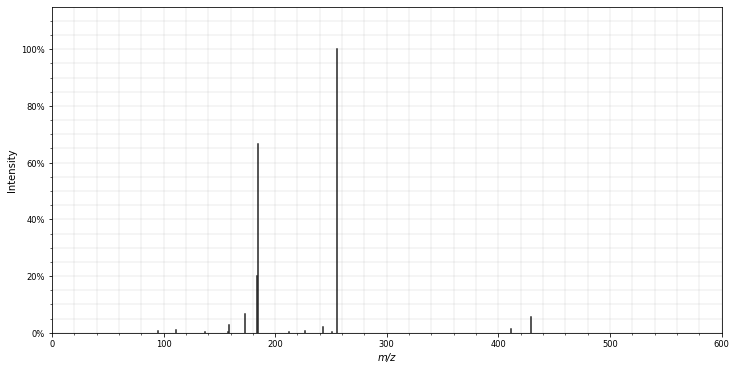

In [5]:
data = unique_data.iloc[32]
print("num peaks: ")
print(len(data['m/z']))
print(len(data['intensity']))
show_spectrum(data)

(0, 600.0)

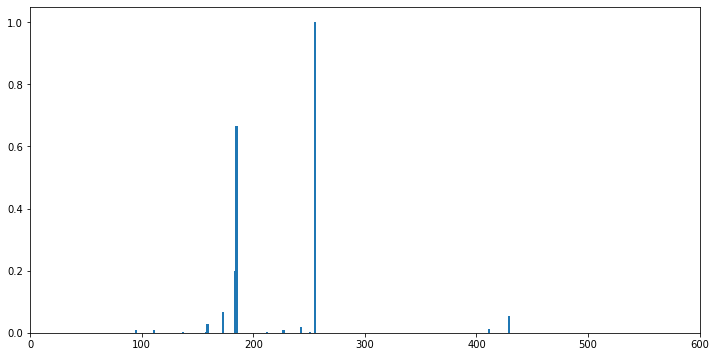

In [6]:
## verify binning results in a similar plot
bin_size = 1
binned = bin_spectra(data, bin_size)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.bar(range(len(binned)), binned, width=2)
ax.set_xlim(0, 600/bin_size)


In [7]:
def count_peaks(data, threshold):
    peak_counter = {i:0 for i in range(601)}
    for i, mol in data.iterrows():
        binned = bin_spectra(mol, 1)
        for bin_no, intensity in enumerate(binned):
            if intensity > threshold:
                peak_counter[bin_no] += 1
    
    return peak_counter

In [8]:
## find most common large peak
# peaks = count_peaks(unique_data, 0.9)
# max_peak = max(peaks.items(), key=operator.itemgetter(1))[0]
max_peak = 121

In [9]:
##### predict only bin 121
x_data = []
y_data = []

for i, mol in unique_data.iterrows():
    sys.stdout.write("Binning: %d   \r" % (i + 1) )
    sys.stdout.flush()
    binned = bin_spectra(mol, 1)
    x_data.append(mol['fingerprint'])
    y_data.append(binned[max_peak])
    
    
split = int(0.8 * len(x_data))
    
x_train = np.array(x_data[:split])
y_train = np.array(y_data[:split])

x_test = np.array(x_data[split:])
y_test = np.array(y_data[split:])

len(x_data)

/home/cameron/cs/project/src/data_utils.py:68: RuntimeWarning: invalid value encountered in true_divide
  return array / max(array)


8239

In [10]:
x2_data = []
y2_data = []

for i, val in enumerate(y_data):
    if val > 0.1:
        x2_data.append(x_data[i])
        y2_data.append(val)
        
split2 = int(0.8 * len(x2_data))
        
x2_train = np.array(x2_data[:split2])
y2_train = np.array(y2_data[:split2])

x2_test = np.array(x2_data[split2:])
y2_test = np.array(y2_data[split2:])

len(x2_data)

844

In [11]:
### First working MLP
# model = Sequential()
# model.add(Dense(units=1024, activation='sigmoid', input_shape=(2048,)))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(1, activation='linear'))
# sgd = optimizers.SGD(lr=0.01, nesterov=True);
# model.compile(loss='mean_absolute_error', optimizer=sgd)

In [12]:
model = Sequential()
model.add(Dense(units=1024, activation='sigmoid', input_shape=(2048,)))

model.add(Dense(units=512, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=64, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1))

#model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
#model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
#model.fit(np.array(x_data), np.array(y_data), epochs=10, batch_size=10, verbose=1, validation_split=0.2)


sgd = optimizers.SGD(lr=0.01, nesterov=True);
rmsprop = optimizers.RMSprop(learning_rate=0.01, rho=0.9)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse', 'mae', 'mape', 'cosine'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

In [13]:
history = model.fit(x2_train, y2_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Train on 540 samples, validate on 135 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_1140 in device /job:localhost/replica:0/task:0/device:GPU:0
540/540 [==============================] - 1s 2ms/step - loss: 10.3475 - mse: 10.3475 - mae: 1.7374 - mape: 758.3250 - cosine: 0.5259 - val_loss: 0.2409 - val_mse: 0.2409 - val_mae: 0.4710 - val_mape: 267.3289 - val_cosine: 1.0000
Epoch 2/50
540/540 [==============================] - 0s 251us/step - loss: 0.1146 - mse: 0.1146 - mae: 0.2746 - mape: 117.1073 - cosine: 1.0000 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1791 - val_mape: 72.1836 - val_cosine: 1.0000
Epoch 3/50
540/540 [==============================] - 0s 245us/step - loss: 0.2965 - mse: 0.2965 - mae: 0.4209 - mape: 182.3595 - cosine: 0.6593 - val_loss: 0.1798 - val_mse: 0.1798 - val_mae: 0.4082 - val_mape: 228.9948 - val_cosine: 1.0000
Epoch 4/50
540/540 [==============================] - 0s 257us/step - loss: 0.1388 - mse: 0.1388 - mae: 0.3032 - mape: 126.7

540/540 [==============================] - 0s 246us/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1064 - mape: 33.9061 - cosine: 1.0000 - val_loss: 0.0609 - val_mse: 0.0609 - val_mae: 0.1631 - val_mape: 70.8642 - val_cosine: 1.0000
Epoch 34/50
540/540 [==============================] - 0s 240us/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0930 - mape: 30.2084 - cosine: 1.0000 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.1614 - val_mape: 48.9269 - val_cosine: 1.0000
Epoch 35/50
540/540 [==============================] - 0s 258us/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1062 - mape: 35.1538 - cosine: 1.0000 - val_loss: 0.0713 - val_mse: 0.0713 - val_mae: 0.1828 - val_mape: 86.8389 - val_cosine: 1.0000
Epoch 36/50
540/540 [==============================] - 0s 246us/step - loss: 0.0213 - mse: 0.0213 - mae: 0.0970 - mape: 30.8577 - cosine: 1.0000 - val_loss: 0.0607 - val_mse: 0.0607 - val_mae: 0.1622 - val_mape: 62.3377 - val_cosine: 1.0000
Epoch 37/50
540/540 [===========================

In [14]:
results = model.evaluate(x2_test, y2_test, batch_size=128, verbose=1)
labels = model.metrics_names

for i in range(len(results)):
    print(labels[i], results[i])

169/169 [==============================] - 0s 69us/step
loss 0.08382102520860864
mse 0.08382102847099304
mae 0.21736817061901093
mape 81.84187316894531
cosine 1.0


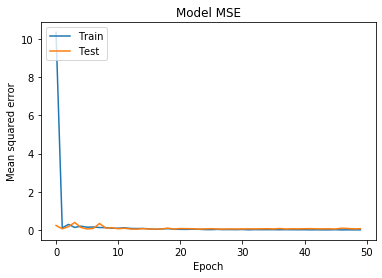

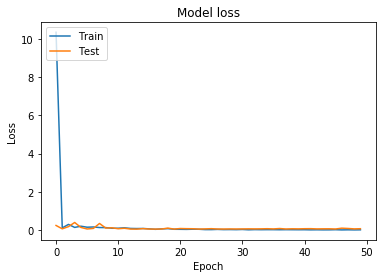

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()